In [1]:
import pandas as pd
import os
import glob

def read_csv_files_from_folder(folder_path):
    """
    Reads all CSV files from a specified folder and merges them into a single DataFrame.

    Parameters:
    folder_path (str): The path to the folder containing CSV files.

    Returns:
    pd.DataFrame: A Pandas DataFrame containing the merged data or None if no data is found.
    """
    try:
        # Create an empty list to store DataFrames
        dfs = []

        # Use glob to get a list of all CSV files in the folder
        csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

        if not csv_files:
            print("No CSV files found in the specified folder.")
            return None

        # Read and append each CSV file to the list
        for csv_file in csv_files:
            df = pd.read_csv(csv_file)
            if not df.empty:
                dfs.append(df)

        if not dfs:
            print("No valid data found in the CSV files.")
            return None

        # Concatenate all DataFrames vertically
        merged_df = pd.concat(dfs, ignore_index=True)

        return merged_df
    except FileNotFoundError:
        print("The specified folder or CSV files were not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

In [2]:
# Reading the dataset using our custom function
df = read_csv_files_from_folder("data")

# Take a look at the first 5 rows of the dataset
df.head()


,label,animal_ID,segment_ID,timestamp_ms,ax,ay,az,axhg,ayhg,azhg,cx,cy,cz,gx,gy,gz,pressure,temp
0,walking,G1,1,1,1.57538,4.34787,-9.27514,5.61615,8.19897,10.21120,-0.5685,-0.7875,2.5245,10.54880,-28.4756,91.9512,NaN,28.16
1,walking,G1,1,6,1.47962,4.30477,-9.31105,4.98546,8.64947,4.47490,NaN,NaN,NaN,9.51220,-27.0732,88.1707,NaN,28.15
2,walking,G1,1,11,1.36469,4.24492,-9.42118,5.19569,9.25012,5.79634,-0.5850,-0.7830,2.5260,9.57317,-25.2439,83.9634,NaN,28.16
3,walking,G1,1,16,1.21386,4.22816,-9.59835,4.23463,8.82966,9.28016,NaN,NaN,NaN,11.21950,-22.9878,79.2683,NaN,28.16
4,walking,G1,1,21,1.07021,4.29520,-9.67257,5.13562,7.89864,5.88644,-0.5835,-0.7815,2.5215,13.47560,-19.8780,73.8415,NaN,28.14


In [3]:
# Selecting specific columns from the dataset
selected_columns = ['label', 'animal_ID', 'timestamp_ms', 'ax', 'ay', 'az']
new_df = df[selected_columns]

new_df.head()

,label,animal_ID,timestamp_ms,ax,ay,az
0,walking,G1,1,1.57538,4.34787,-9.27514
1,walking,G1,6,1.47962,4.30477,-9.31105
2,walking,G1,11,1.36469,4.24492,-9.42118
3,walking,G1,16,1.21386,4.22816,-9.59835
4,walking,G1,21,1.07021,4.29520,-9.67257


In [4]:
# Import libraries
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Remove null values if any
df = new_df.dropna()
df.shape

(13778153, 6)

In [6]:
#arrange data in ascending order of user and timestamp
df = df.sort_values(by = ['animal_ID', 'timestamp_ms'], ignore_index=True)

In [10]:
df['label'].value_counts()

standing          6031069
grazing           3735835
walking           2109794
lying              984396
trotting           408051
running            324775
scratch_biting      92715
fighting            75209
shaking             16309
Name: label, dtype: int64

In [15]:
# Defining a list of labels to be assigned as "other"
labels_to_be_assigned_as_other = ["scratch_biting", "fighting", "shaking"]

# Update the labels in the DataFrame
df['label'] = df['label'].apply(lambda x: 'other' if x in labels_to_be_assigned_as_other else x)

# Now, the labels in the DataFrame have been updated, and the specified labels are assigned as "other"


In [16]:
df['label'].value_counts()

standing    6031069
grazing     3735835
walking     2109794
lying        984396
trotting     408051
running      324775
other        184233
Name: label, dtype: int64

In [26]:
# Importing stats from scipy
from scipy import stats

# Defining constants and hyperparameters
random_seed = 42   
n_time_steps = 1000  # 1000 time steps for each segment
n_features = 3  # Number of features (x, y, z)
step = 200  # Step size for segmenting
n_classes = 7  # Number of classes
n_epochs = 50       
l2_loss = 0.0015


segments = []
labels = []

# Iterate over the data with a moving window of 1000 time steps
for i in range(0, df.shape[0] - n_time_steps, step):
    x = df['ax'].values[i: i + n_time_steps]
    y = df['ay'].values[i: i + n_time_steps]
    z = df['az'].values[i: i + n_time_steps]

    # Calculate the mode of the 'label' column within the segment
    label = stats.mode(df['label'][i: i + n_time_steps])[0][0]

    # Create a segment that includes data from all three axes
    segment = [x, y, z]

    segments.append(segment)
    labels.append(label)

# Reshape the segments into a 3D array
reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, n_time_steps, n_features)


In [27]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on your list of labels
label_encoder.fit(labels)

# Transform the original labels into encoded labels
encoded_labels = label_encoder.transform(labels)

In [28]:
reshaped_segments.shape, encoded_labels.shape

((68886, 1000, 3), (68886,))

In [29]:
encoded_labels

array([6, 6, 6, ..., 5, 5, 5])

In [36]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define constants and hyperparameters
input_size = n_features
hidden_size = 128
num_layers = 1  # Number of layers
num_classes = n_classes
dropout_prob = 0.5
learning_rate = 0.001  
batch_size = 256  

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(reshaped_segments, encoded_labels, test_size=0.3, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_seed)

# Normalize the data using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(-1, n_time_steps, n_features)
X_val = scaler.transform(X_val.reshape(-1, n_features)).reshape(-1, n_time_steps, n_features)
X_test = scaler.transform(X_test.reshape(-1, n_features)).reshape(-1, n_time_steps, n_features)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)  

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.int64)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [46]:
import torch.nn as nn
import torch

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, seq_length, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Reshape the input data to match the expected format (batch_size, seq_length, input_size)
        x = x.view(-1, self.seq_length, self.input_size)
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        
        return out

# Define the model and parameters
input_size = 3  
hidden_size = 128
num_layers = 1
num_classes = 7  
seq_length = 1000  

model = LSTMModel(input_size, hidden_size, num_layers, num_classes, seq_length)



In [47]:
# Check if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU
model.to(device)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_loss)

# Initialize lists to store training and validation loss, accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    average_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    
    # Validation
    model.eval()
    total_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_accuracy = correct_val / total_val
    average_val_loss = total_loss / len(val_loader)
    
    print(f'Epoch [{epoch + 1}/{n_epochs}], '
          f'Training Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    
    # Store the loss and accuracy for plotting
    train_losses.append(average_loss)
    val_losses.append(average_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

print('Training finished!')


Epoch [1/50], Training Loss: 1.4084, Training Accuracy: 0.4282, Validation Loss: 1.2204, Validation Accuracy: 0.4532
Epoch [2/50], Training Loss: 1.2183, Training Accuracy: 0.4717, Validation Loss: 1.2633, Validation Accuracy: 0.4543
Epoch [3/50], Training Loss: 1.1148, Training Accuracy: 0.5360, Validation Loss: 0.9810, Validation Accuracy: 0.5920
Epoch [4/50], Training Loss: 0.8823, Training Accuracy: 0.6402, Validation Loss: 1.0673, Validation Accuracy: 0.4839
Epoch [5/50], Training Loss: 0.8558, Training Accuracy: 0.6457, Validation Loss: 0.7474, Validation Accuracy: 0.6926
Epoch [6/50], Training Loss: 0.7679, Training Accuracy: 0.6914, Validation Loss: 0.7675, Validation Accuracy: 0.6946
Epoch [7/50], Training Loss: 0.7952, Training Accuracy: 0.6804, Validation Loss: 0.8640, Validation Accuracy: 0.6345
Epoch [8/50], Training Loss: 0.7698, Training Accuracy: 0.6960, Validation Loss: 0.7790, Validation Accuracy: 0.6952
Epoch [9/50], Training Loss: 0.9938, Training Accuracy: 0.6002, 

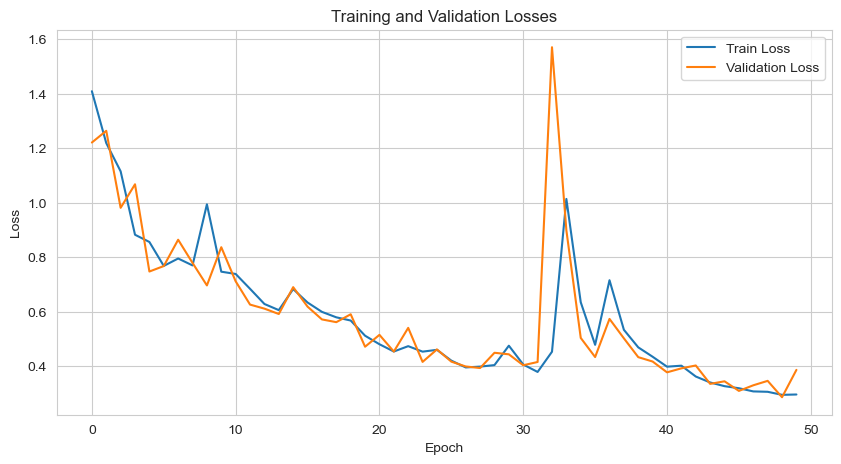

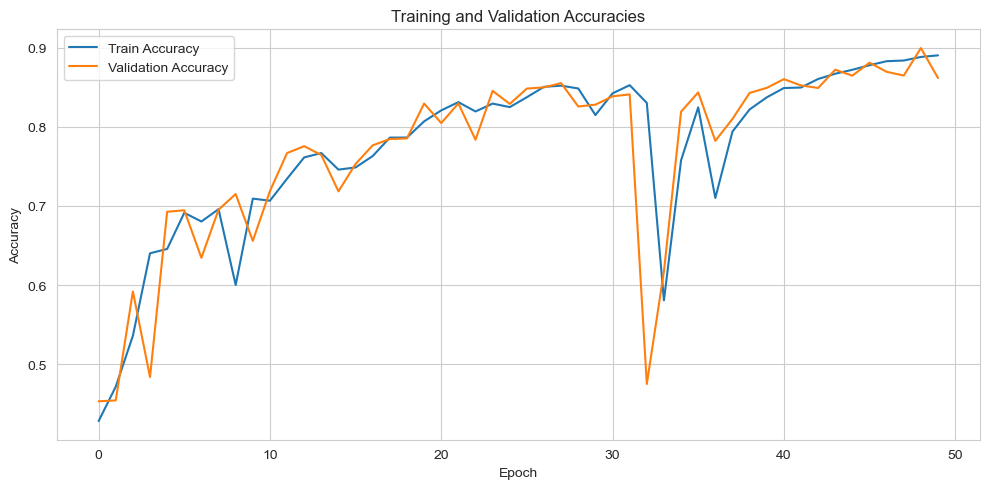

In [51]:
import matplotlib.pyplot as plt

# Plotting losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss.png', dpi=300)


# Plotting accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy.png', dpi=300)


# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the combined plot as an image file
plt.savefig('accuracy_loss.png', dpi=300)

# Show the combined plot
plt.show()

In [48]:
model.eval()
total_test = 0
correct_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.8619
